In [1]:
from drn_interactions.spikes import SpikesHandler
from drn_interactions.load import load_neurons, get_fig_dir

from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, RobustScaler

In [2]:
def load_dat_data(p, n_chans=32, white=False):
    if not white: 
        p = p / (p.name + ".dat")
    else:
        p = p / ("temp_wh.dat")
    tmp = np.memmap(p, dtype=np.int16)
    shp = int(len(tmp) / n_chans)
    return np.memmap(p, dtype=np.int16,
                     shape=(shp, n_chans))


def load_pc(p):
    p = p / ("pc_features.npy")
    return np.load(p)

def load_generic(p, name):
    p = p / (f"{name}.npy")
    return np.load(p)

In [3]:
sns.set_context("poster")
plt.rc("axes.spines", top=False, right=False, left=False, bottom=False)
# sns.set_theme("")

In [4]:
outdir = get_fig_dir() / "ephys_model"
outdir.mkdir(exist_ok=True, parents=True)

In [5]:
rec = 'hamilton_35'
p = Path(r"D:\HAMILTON\probe_dat_dir") / rec

out = load_dat_data(p, white=True)

t_start = 620   * 30000
t_stop =  t_start + 10   * 30000
interval = 200
data = out[t_start:t_stop:interval, :]
data = MinMaxScaler().fit_transform(data)
df = pd.DataFrame(data)
for i, col in enumerate(df.columns):
    df[col] = df[col].add(i * 1.1)

_, ax = plt.subplots()
ax.axis("off")
ax = df.plot(color="black", figsize=(15, 5), ax=ax)

ax.get_legend().remove()
# plt.savefig(outdir / "raw_data.png", dpi=300)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\HAMILTON\\probe_dat_dir\\hamilton_35\\temp_wh.dat'

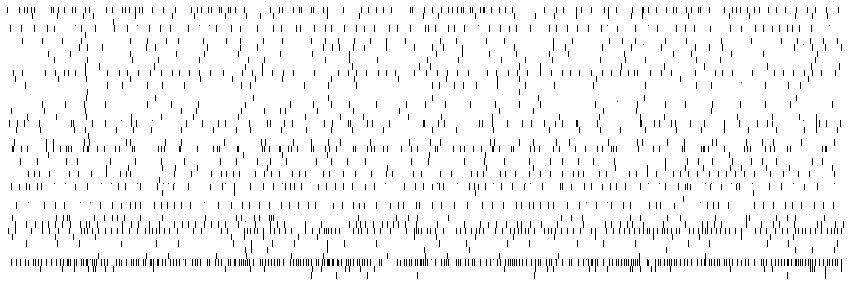

In [109]:
sh = SpikesHandler(
    block="pre",
    bin_width=0.01,
    session_names=[rec],
    t_start = t_start / 30000,
    t_stop =  t_stop / 30000, 
)
df_sorted = sh.binned_piv
f = plt.figure(figsize=(15, 5))

ax = sns.heatmap(df_sorted.transpose(), cmap="Greys", vmax=1, cbar=False, xticklabels=False, yticklabels=False)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.savefig(outdir / "sorted_spikes.png", dpi=300)

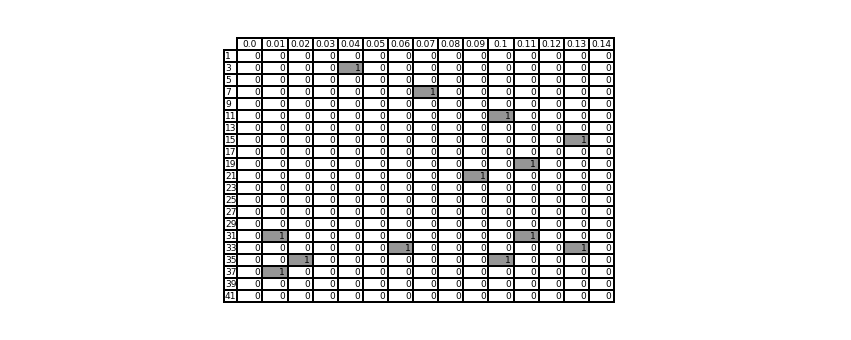

In [102]:
for i, c in enumerate(df_sorted.columns):
    df_sorted.rename(columns={c:str(i)}, inplace=True)
df_sorted.index = np.round(df_sorted.index - np.min(df_sorted.index), 2)
df = df_sorted.transpose().iloc[1::2, :15]
df.index.name = "neuron"
vals = np.round(df.values, 2)

norm = plt.Normalize(vals.min(), vals.max()+1)
colours = plt.cm.Greys(norm(vals))

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])

the_table=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
                    colWidths = [0.03]*vals.shape[1], loc='center', 
                    cellColours=colours)
# plt.savefig(outdir / "spike_vectors.png", dpi=300)

In [51]:
pcs = load_pc(p)
good_clusters = pd.read_csv(p / "cluster_KSLabel.tsv", sep="\t")
good_clusters = good_clusters[good_clusters["KSLabel"] == "good"]["cluster_id"].unique()
spike_clusters = load_generic(p, "spike_clusters")

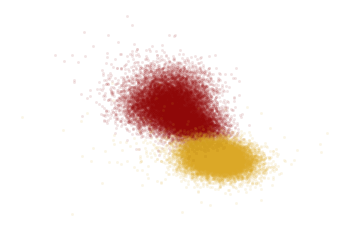

In [108]:
n1 = 143
n2 = 98

n1_spikes = spike_clusters == n1
n1_pcs = np.squeeze(pcs[n1_spikes, :3, :])
best_chan = int(np.median(np.argmax(n1_pcs, axis=1)))
n1_pcs = np.squeeze(n1_pcs[:, :, best_chan])
df_n1 = pd.DataFrame(n1_pcs, columns=["pc1", "pc2", "pc3"]).astype(float)
df_n1["neuron"] = "first"


n2_spikes = spike_clusters == n2
n2_pcs = np.squeeze(pcs[n2_spikes, :3, :])
# n2_pcs = np.mean(n2_pcs, axis=2)
n2_pcs = np.squeeze(n2_pcs[:, :, best_chan])
df_n2 = pd.DataFrame(n2_pcs, columns=["pc1", "pc2", "pc3"]).astype(float)
df_n2["neuron"] = "second"

df_pc = pd.concat([df_n1, df_n2])


fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(data=df_pc.query("neuron == 'first'"), x="pc2", y="pc1", alpha=0.1, s=1, color="darkred", label="first")
ax.scatter(data=df_pc.query("neuron == 'second'"), x="pc2", y="pc1", alpha=0.1, s=1, color="goldenrod", label="second")
ax.axis("off")
plt.savefig(outdir / "PCs.png", dpi=300)

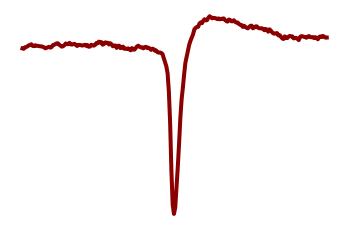

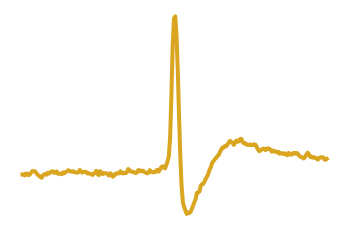

In [56]:
from drn_interactions.load import load_waveforms

df_waveforms = load_waveforms().assign(time = lambda x: x["waveform_index"].divide(30)).pivot(index="time", columns="neuron_id", values="waveform_value")

plt.figure()
ax = df_waveforms.loc[:, 1875].plot(color="darkred", linewidth=4)
ax.axis("off")
plt.savefig(outdir / "waveform1.svg", dpi=300)

plt.figure()
ax = df_waveforms.loc[:, 1858].plot(color="goldenrod", linewidth=4)
ax.axis("off")
plt.savefig(outdir / "waveform2.svg", dpi=300)
